# Résolution du problème d'optimisation

### Le problème:

L'OTS cherche à minimiser les coûts d’exploitation du réseau électrique en choisissant la meilleure topologie de réseau, c'est-à-dire en décidant quelles lignes de transmission doivent rester actives ou non. Cela mène à un problème de programmation mixte en nombres entiers (MILP), très difficile à résoudre (NP-difficile).

$ min \sum_{i \in G} c_i g_i$

Avec les contraintes:

- $\sum_{b \in L^+} l_b +\sum_{i \in G} g_i = \sum_{b \in L^+} l_b +\sum_{i \in N} d_i$


Avec: $L^+$ (resp $L^-$) est le flux entrant dans une ligne (resp sortant) tq b=(i,j). G est l'ensemble des générateurs et N est l'ensemble des noeuds. 

Ou encore: $g_i - d_i=\sum l_{ij}-\sum l_{ji}$ pour $i\in B$

- $ |l_{i,j}| \leq L_{i,j} \quad \forall (i,j) \in L_n$  ,assure que le flux de puissance $l_{i,j}$ dans chaque ligne (i, j) ne dépasse pas la capacité maximale $L_{i,j}$ de la ligne.

- $P_i^{\min} \leq g_i \leq P_i^{\max} \quad \forall i \in B $ ,impose que la puissance générée par chaque générateur i soit entre sa capacité minimale $P_i^{\min}$
et sa capacité maximale $P_i^{\max}$.

-  $l_{i,j} = \delta_{i,j}  \frac{\theta_i - \theta_j}{X_{i,j}} \quad \forall (i,j) \in L $ , utilise l’approximation DC pour modéliser les relations entre les flux de puissance $l_{i,j}$ , les angles de phase θi et θj , et la réactance inductive de la bobine. $X_{i,j}$ de la ligne (i, j).

- $g_i \in \mathbb{R} \quad \forall i \in G $

- $l_{i,j} \in \mathbb{R} \quad \forall (i,j) \in L$

- $\delta_{i,j} \in \{0,1\} \quad \forall (i,j) \in L$


##  Méthode classique:

Travaillons sur cet exemple:

C:\Users\TACHI\AppData\Local\Temp\ipykernel_21932\341096697.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


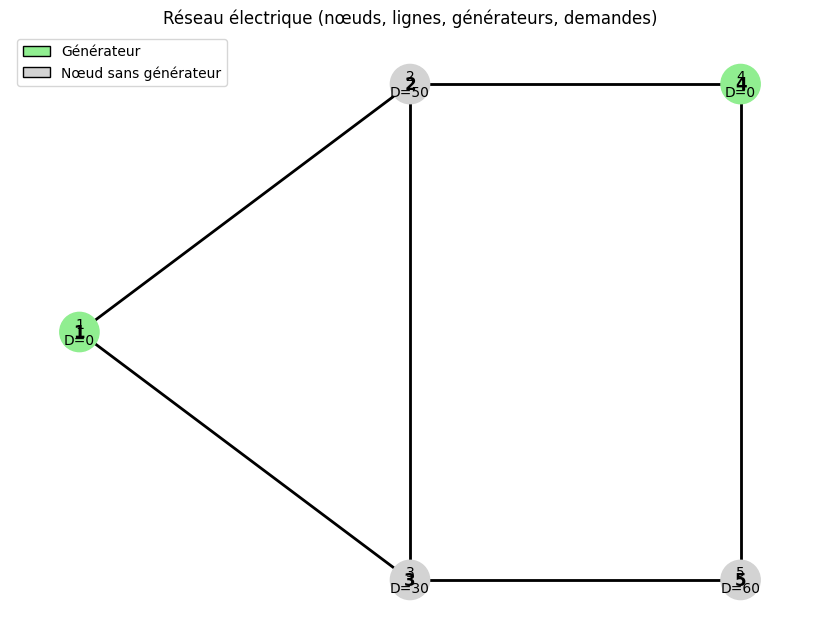

In [130]:
import networkx as nx
import matplotlib.pyplot as plt

# Données du graphe
nodes = [1, 2, 3, 4, 5]
lines = [(1, 2), (1, 3), (2, 3), (2, 4), (3, 5), (4, 5)]
generators = [1, 4]
demand = {1: 0, 2: 50, 3: 30, 4: 0, 5: 60}

# Création du graphe
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(lines)

# Position des nœuds (fixe pour lisibilité)
pos = {
    1: (0, 1),
    2: (1, 2),
    3: (1, 0),
    4: (2, 2),
    5: (2, 0)
}

# Couleurs des nœuds : générateurs en vert, autres en gris
node_colors = ['lightgreen' if node in generators else 'lightgray' for node in G.nodes()]

# Dessin du graphe
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=800, font_size=12, font_weight='bold')
nx.draw_networkx_edges(G, pos, width=2)

# Ajout des demandes comme labels
labels = {node: f"{node}\nD={demand[node]}" for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=10)

# Légende
from matplotlib.patches import Patch


legend_elements = [
    Patch(facecolor='lightgreen', edgecolor='k', label='Générateur'),
    Patch(facecolor='lightgray', edgecolor='k', label='Nœud sans générateur')
]
plt.legend(handles=legend_elements, loc='upper left')

plt.title("Réseau électrique (nœuds, lignes, générateurs, demandes)")
plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
nodes = [1, 2, 3, 4, 5]
lines = [(1, 2), (1, 3), (2, 3), (2, 4), (3, 5), (4, 5)]
generators = [1, 4]

# Paramètres
demand = {1: 0, 2: 50, 3: 30, 4: 0, 5: 60}
cost = {1: 1, 4: 2}
Pmin = {1: 0, 4: 0}
Pmax = {1: 100, 4: 100}
X = {
    (1, 2): 0.1,
    (1, 3): 0.2,
    (2, 3): 0.3,
    (2, 4): 0.25,
    (3, 5): 0.15,
    (4, 5): 0.2
}
Lmax = {line: 100 for line in lines}


Résolution de OTS:

In [132]:
import pulp

# Sets
nodes = [1, 2, 3, 4, 5]
lines = [(1, 2), (1, 3), (2, 3), (2, 4), (3, 5), (4, 5)]
generators = [1, 4]

# Parameters
demand = {1: 0, 2: 30, 3: 40, 4: 0, 5: 60}
cost = {1: 1, 4: 2}
Pmin = {1: 0, 4: 0}
Pmax = {1: 100, 4: 100}
X = {(1, 2): 0.1, (1, 3): 0.2, (2, 3): 0.3, (2, 4): 0.1, (3, 5): 0.2, (4, 5): 0.3}
Lmax = {k: 100 for k in X}
M = 1000  # Grande constante

# Model
model = pulp.LpProblem("DC_OPF_with_switches", pulp.LpMinimize)

# Variables
g = pulp.LpVariable.dicts("g", generators, lowBound=0)
theta = pulp.LpVariable.dicts("theta", nodes, cat="Continuous")
l = pulp.LpVariable.dicts("l", lines, lowBound=-1000, upBound=1000)
delta = pulp.LpVariable.dicts("delta", lines, cat="Binary")
theta_diff = pulp.LpVariable.dicts("theta_diff", lines, lowBound=-1000, upBound=1000)

# Objective
model += pulp.lpSum(cost[i] * g[i] for i in generators)

# Slack bus
model += theta[1] == 0

# Power balance
for i in nodes:
    inflow = pulp.lpSum(l[(j, i)] for (j, k) in lines if k == i) + \
             pulp.lpSum(-l[(i, j)] for (i2, j) in lines if i2 == i)
    generation = g[i] if i in generators else 0
    model += generation + inflow == demand[i], f"PowerBalance_{i}"

# Generation constraints
for i in generators:
    model += g[i] >= Pmin[i]
    model += g[i] <= Pmax[i]

# Line capacity
for (i, j) in lines:
    model += l[(i, j)] <= Lmax[(i, j)] * delta[(i, j)]
    model += l[(i, j)] >= -Lmax[(i, j)] * delta[(i, j)]

# Define theta_diff
for (i, j) in lines:
    model += theta_diff[(i, j)] == theta[i] - theta[j]

# Enforce DC flow if delta = 1, and l = 0 if delta = 0
for (i, j) in lines:
    model += l[(i, j)] - (1 / X[(i, j)]) * theta_diff[(i, j)] <= M * (1 - delta[(i, j)])
    model += l[(i, j)] - (1 / X[(i, j)]) * theta_diff[(i, j)] >= -M * (1 - delta[(i, j)])

# Solve
solver = pulp.PULP_CBC_CMD(msg=1)
model.solve(solver)

# Results
print("\n=== Résultats ===")
for i in generators:
    print(f"Générateur {i} : {g[i].varValue:.2f} MW")

for (i, j) in lines:
    print(f"Ligne {i}-{j} : flux = {l[(i,j)].varValue:.2f} MW | delta = {int(delta[(i,j)].varValue)}")

for i in nodes:
    print(f"Angle θ_{i} = {theta[i].varValue:.2f} rad")

print("\nCoût total :", pulp.value(model.objective))



=== Résultats ===
Générateur 1 : 100.00 MW
Générateur 4 : 30.00 MW
Ligne 1-2 : flux = 100.00 MW | delta = 1
Ligne 1-3 : flux = 0.00 MW | delta = 0
Ligne 2-3 : flux = 0.00 MW | delta = 0
Ligne 2-4 : flux = 70.00 MW | delta = 1
Ligne 3-5 : flux = -40.00 MW | delta = 1
Ligne 4-5 : flux = 100.00 MW | delta = 1
Angle θ_1 = 0.00 rad
Angle θ_2 = -10.00 rad
Angle θ_3 = -55.00 rad
Angle θ_4 = -17.00 rad
Angle θ_5 = -47.00 rad

Coût total : 160.0


Le graphe après l'optimisation:

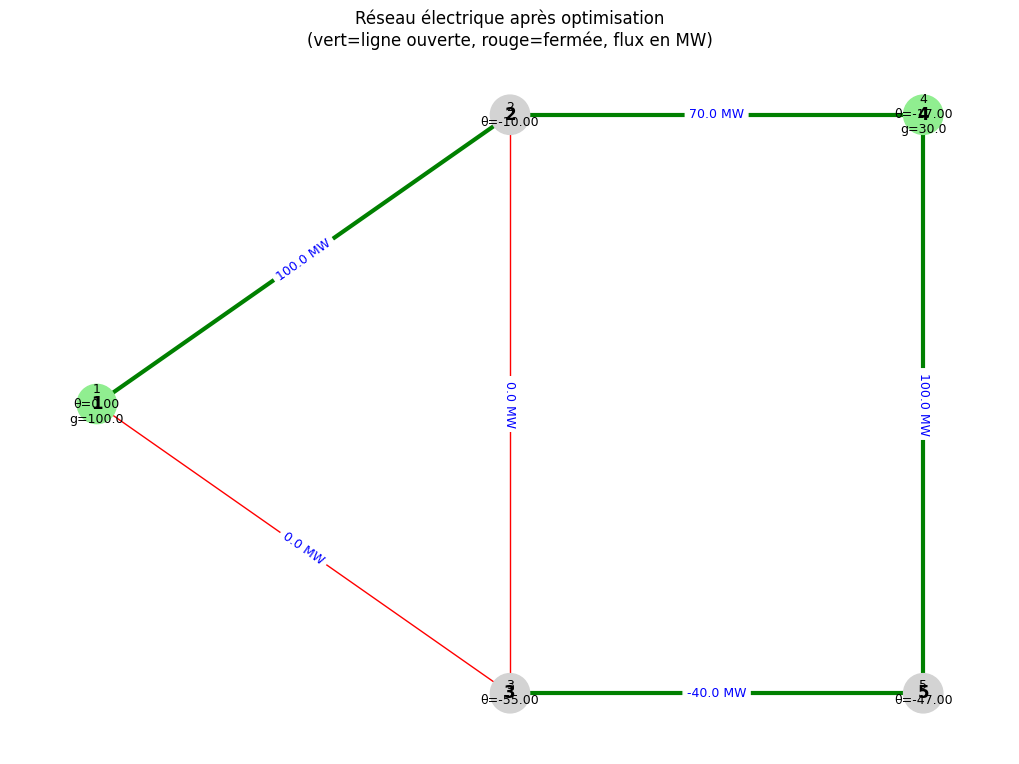

In [133]:
# Graphe après optimisation: 

G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(lines)

# Position des nœuds
pos = {
    1: (0, 1),
    2: (1, 2),
    3: (1, 0),
    4: (2, 2),
    5: (2, 0)
}

node_colors = ['lightgreen' if n in generators else 'lightgray' for n in nodes]

edge_colors = []
edge_widths = []
for (i,j) in lines:
    if delta[(i,j)].varValue > 0.5:
        edge_colors.append('green')
        edge_widths.append(3)
    else:
        edge_colors.append('red')
        edge_widths.append(1)

plt.figure(figsize=(10,7))
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=800, font_weight='bold', font_size=12,
        edge_color=edge_colors, width=edge_widths)

edge_labels = {(i,j): f"{l[(i,j)].varValue:.1f} MW" for (i,j) in lines}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='blue', font_size=9)

node_labels = {}
for n in nodes:
    gen_str = f"\ng={g[n].varValue:.1f}" if n in generators else ""
    node_labels[n] = f"{n}\nθ={theta[n].varValue:.2f}{gen_str}"
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=9, font_weight='normal')

plt.title("Réseau électrique après optimisation\n(vert=ligne ouverte, rouge=fermée, flux en MW)")
plt.axis('off')
plt.show()

## Méthode quantique:

In [117]:
# Modules
from qiskit.quantum_info import Pauli, SparsePauliOp
from itertools import combinations
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
import numpy as np
from scipy.optimize import minimize
from functools import reduce


---> Un cas particulier de notre problème

Considérons une version simplifiée de notre problème d’optimisation :


$\min_{g_i} \sum_{i \in G} c_i g_i$


sous les contraintes :


$0 \leq g_i \leq P_i \quad \forall i \in B$

$\sum_{i \in B} g_i = \sum_{i \in B} D_i$

où les  $c_i$  sont des coefficients constants représentant les coûts associés, et $P_i$ sont des entiers naturels représentant les limites supérieures des variables $g_i$.


Pour décrire un entier $g_i \in \{0, \ldots, P_i\} $ avec des variables binaires, une approche initiale pourrait consister à introduire $P_i + 1 $ variables binaires $x_0, \ldots, x_{P_i}$ et à remplacer $g_i$ par :

$g_i = \sum_{m = 0}^{P_i}  x_m$


- On définit l'Hamiltonien de coût $H_C$

- On définit l'Hamiltonien de mélange : Nous choisissons le champ transversal, appelé Hamiltonien de mélange, défini par $H_M=\sum X_i$

- État d’entrée : L’état initial de l’algorithme est $\left| + \right\rangle^{\otimes n}$ qui est l’état propre unique associé à la plus
grande valeur propre de $H_M$

- QAOA ANSATZ:c'est une forme paramétrée de circuit quantique servant à approximer la solution optimale d’un problème d’optimisation.

L’ansatz de QAOA à $p$ couches est défini par :

$\ket{\psi_p(\boldsymbol{\gamma}, \boldsymbol{\beta})} = U_p(\boldsymbol{\gamma}, \boldsymbol{\beta}) \ket{+}^{\otimes n}$  où $\ket{+}^{\otimes n}$ est l’état initial (superposition uniforme sur $n$ qubits), et :

$U_p(\boldsymbol{\gamma}, \boldsymbol{\beta}) = \prod_{k=1}^p \left( e^{-i \beta_k H_M} \cdot e^{-i \gamma_k H_C} \right)$


---> L’objectif est de trouver les paramètres $(\boldsymbol{\gamma}^\ast, \boldsymbol{\beta}^\ast)$ qui minimisent la valeur attendue :


$F_p(\boldsymbol{\gamma}, \boldsymbol{\beta}) = \bra{\psi_p(\boldsymbol{\gamma}, \boldsymbol{\beta})} H_C \ket{\psi_p(\boldsymbol{\gamma}, \boldsymbol{\beta})}$

In [134]:
# Les valeurs / exemples
#n = 3  n_qubits = P_i, un seul générateur → P_i qubits
q=3 #bits par générateur 
P_i   = [3,2,2]          # granularité (3 qubits)
c_i   = [10,8,7]       # coût linéaire
D_i   = [30,20,10]        # demande par noeud
D_tot=np.sum(D_i)
nqubit=sum(P_i)


Travaillons donc sur trois noeuds:

In [135]:
#Définition de L'Hamiltonien de mélange
from qiskit.quantum_info import SparsePauliOp

H_M = SparsePauliOp.from_list([
    ('I'*i + 'X' + 'I'*(nqubit-i-1), 1.0)
    for i in range(nqubit)
])

print(H_M)


SparsePauliOp(['XIIIIII', 'IXIIIII', 'IIXIIII', 'IIIXIII', 'IIIIXII', 'IIIIIXI', 'IIIIIIX'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


Pour construire $H_c$: 

- Définir le nombre de générateurs n et le nombre de bits q par générateur (chaque générateur peut produire jusqu’à 2q−1 unités de puissance)

- Introduire les variables binaires $xi,j\in{0,1}$ pour $i=0,…,n−1$ et  $j=0,…,q−1$

- Représenter la puissance générée par chaque générateur gi comme une somme pondérée de ses bits : $gi=\sum_{j=0}^{P_i} x_ij$

- Écrire le terme de coût comme une somme pondérée des gi​ : $Coût=\sum_{i=0}^{n−1} c_ig_i​$

- Écrire le terme de pénalité quadratique pour la contrainte de demande : Pénalité$=λ(\sum_{i=0}^{n−1} g_i−D_{tot})^2$

- Assembler les deux termes pour former le Hamiltonien complet : $H_c(x)=Coût+Pénalité$

- Développer $H_c(x)$ pour obtenir une forme polynomiale avec des termes :

    --> Linéaires, quadratiques


In [136]:
# Initialisation
H1_terms = []
cte1_terms = []
H2_terms = []
lam=100
def qubit_index(i, k):
    return sum(P_i[:i]) + k

for i in range(q):
    for k in range(P_i[i]):
        idx = qubit_index(i, k)
        coeff = (c_i[i] + 2 * lam - 2 * lam * D_tot) / 2
        pauli = ['I'] * nqubit
        pauli[idx] = 'Z'
        H1_terms.append((''.join(pauli), coeff))

# Constante (sur l'identité)
for i in range(q):
    for k in range(P_i[i]):
        coeff = (c_i[i] + lam - 2 * lam * D_tot) / 2 + lam / 4
        cte1_terms.append(('I' * nqubit, coeff))

# Deuxième terme (Z_i Z_j)
for i in range(q):
    for k in range(P_i[i]):
        for j in range(q):
            for l in range(P_i[j]):
                if (i, k) != (j, l):
                    q1 = qubit_index(i, k)
                    q2 = qubit_index(j, l)
                    if q1 < q2:  # éviter doublons
                        pauli = ['I'] * nqubit
                        pauli[q1] = 'Z'
                        pauli[q2] = 'Z'
                        H2_terms.append((''.join(pauli), 1.0))

# Assemblage final
all_terms = H1_terms + cte1_terms + H2_terms
H_c = SparsePauliOp.from_list(all_terms)

# Affichage
print(H_c)

SparsePauliOp(['ZIIIIII', 'IZIIIII', 'IIZIIII', 'IIIZIII', 'IIIIZII', 'IIIIIZI', 'IIIIIIZ', 'IIIIIII', 'IIIIIII', 'IIIIIII', 'IIIIIII', 'IIIIIII', 'IIIIIII', 'IIIIIII', 'ZZIIIII', 'ZIZIIII', 'ZIIZIII', 'ZIIIZII', 'ZIIIIZI', 'ZIIIIIZ', 'IZZIIII', 'IZIZIII', 'IZIIZII', 'IZIIIZI', 'IZIIIIZ', 'IIZZIII', 'IIZIZII', 'IIZIIZI', 'IIZIIIZ', 'IIIZZII', 'IIIZIZI', 'IIIZIIZ', 'IIIIZZI', 'IIIIZIZ', 'IIIIIZZ'],
              coeffs=[-5.8950e+03+0.j, -5.8950e+03+0.j, -5.8950e+03+0.j, -5.8960e+03+0.j,
 -5.8960e+03+0.j, -5.8965e+03+0.j, -5.8965e+03+0.j, -5.9200e+03+0.j,
 -5.9200e+03+0.j, -5.9200e+03+0.j, -5.9210e+03+0.j, -5.9210e+03+0.j,
 -5.9215e+03+0.j, -5.9215e+03+0.j,  1.0000e+00+0.j,  1.0000e+00+0.j,
  1.0000e+00+0.j,  1.0000e+00+0.j,  1.0000e+00+0.j,  1.0000e+00+0.j,
  1.0000e+00+0.j,  1.0000e+00+0.j,  1.0000e+00+0.j,  1.0000e+00+0.j,
  1.0000e+00+0.j,  1.0000e+00+0.j,  1.0000e+00+0.j,  1.0000e+00+0.j,
  1.0000e+00+0.j,  1.0000e+00+0.j,  1.0000e+00+0.j,  1.0000e+00+0.j,
  1.0000e+00+0.j,  1.0000e

In [137]:
from qiskit.circuit.library import PauliEvolutionGate
def U_C(gamma, H):
    gate = PauliEvolutionGate(H, time=gamma)
    return gate.definition  # ou gate.to_instruction().definition

def U_M(beta, H):
    gate = PauliEvolutionGate(H, time=beta)
    return gate.definition


In [138]:
from qiskit import QuantumCircuit

# Construction du circuit QAOA SANS mesure
def build_qaoa_circuit(n, p, gammas, betas, cost_h, mixer_h):
    qc = QuantumCircuit(n)  
    qc.h(range(n))          
    
    for layer in range(p):
        qc.append(U_C(float(gammas[layer]), cost_h), range(n))
        qc.append(U_M(float(betas[layer]), mixer_h), range(n))
    
    return qc 


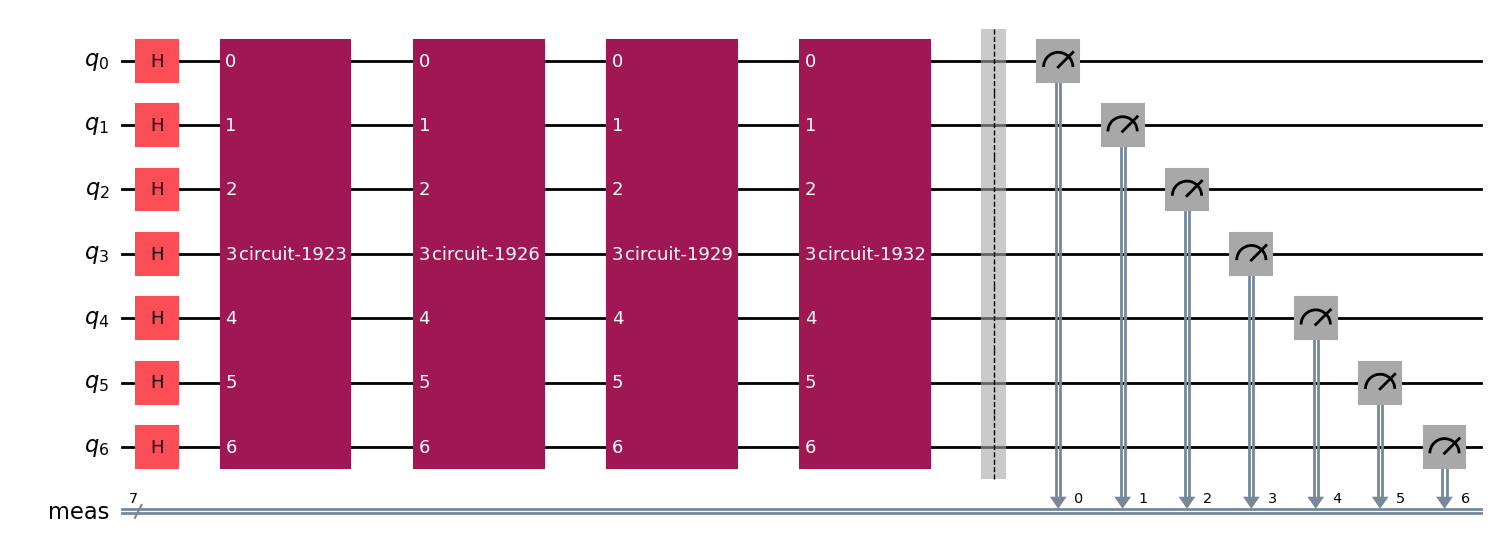

In [139]:
import pylatexenc
p=2 
gammas=[np.pi/4, np.pi/2]
betas=[np.pi/8, np.pi/4]
params=[np.pi/4, np.pi/2, np.pi/8, np.pi/4 ]
cost_h=H_c
mixer_h=H_M
qc=build_qaoa_circuit(nqubit,p,gammas,betas,cost_h,mixer_h)
qc.measure_all()
qc.draw("mpl");

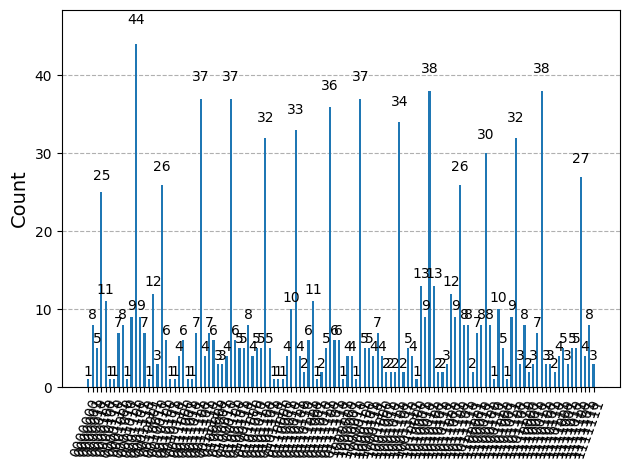

In [140]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer, AerSimulator  
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt


# Transpiler le circuit pour le backend
qc_transpiled = transpile(qc, AerSimulator())

# Exécuter sur le simulateur
job = AerSimulator().run(qc_transpiled, shots=1024)
result = job.result()
counts = result.get_counts()

# Afficher les résultats
plot_histogram(counts)
plt.show()


In [141]:
from qiskit import transpile
from qiskit_aer import Aer
import numpy as np
from scipy.optimize import minimize

backend = Aer.get_backend('aer_simulator')

def qaoa_expectation(params):
    # Supposons que p = 2 (donc 2 gammas et 2 betas)
    p = 2
    gammas = params[:p]
    betas = params[p:]
    
    # Construire le circuit QAOA avec plusieurs couches
    qc = build_qaoa_circuit(nqubit, p, gammas, betas, H_c, H_M)
    qc.save_statevector()
    
    # Transpilation
    qc_transpiled = transpile(qc, backend)
    result = backend.run(qc_transpiled).result()
    
    sv = result.data(0)['statevector']
    expval = sv.expectation_value(H_c)
    return -np.real(expval)  # on maximise le coût en minimisant l'opposé


In [142]:

result = minimize(qaoa_expectation, params, method='COBYLA')

print("Paramètres optimaux :", result.x)
print("Espérance d'énergie minimale :", -result.fun)


Paramètres optimaux : [1.68127486 1.37825354 1.44997051 0.83507747]
Espérance d'énergie minimale : -14428.492900680678


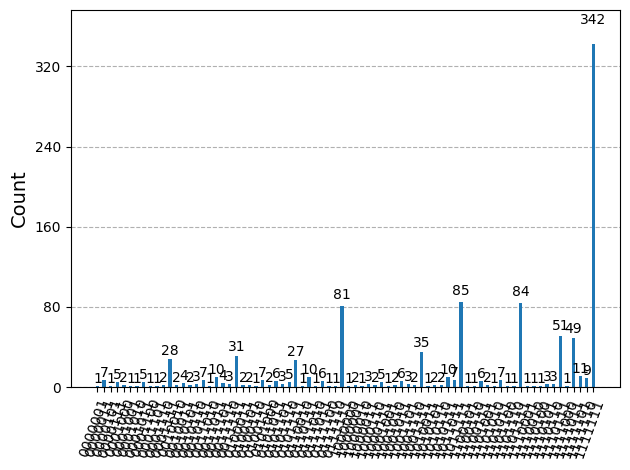

In [143]:
# Séparer les gammas et betas extraits de l'optimisation
p = 2  # nombre de couches QAOA
optimal_gammas = result.x[:p]
optimal_betas = result.x[p:]

# Construire le circuit final optimisé
qc_final = build_qaoa_circuit(nqubit, p, optimal_gammas, optimal_betas, H_c, H_M)
qc_final.measure_all()

# Exécuter sur le simulateur Aer
qc_final_transpiled = transpile(qc_final, backend)
job = backend.run(qc_final_transpiled, shots=1024)
counts = job.result().get_counts()

# Afficher l'histogramme
from qiskit.visualization import plot_histogram
plot_histogram(counts);


In [144]:
# Récupérer le bitstring le plus probable après exécution
best_bitstring = max(counts, key=counts.get)
print("Bitstring le plus probable :", best_bitstring)
print("Nombre d'occurrences :", counts[best_bitstring])


Bitstring le plus probable : 1111111
Nombre d'occurrences : 342


C'est logique comme on détermine la borne sup de la solution optimale.
